# 3. Convolutional Neural Networks (60 pts)

### Implement the convolutional neural network shown below for CIFAR-10 dataset.  Your code must follow these rules:

__- Use your own implementation.__

__- You can only use " tf " and " tf.nn " libraries. Check [tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn)__

__- Use ReLU activation function__

__- Use batch normalization for convolutional layers__

__- Use dropout for fully connected layers (for training only)__

__- Write necessary explanations for each cell. Explanations should be detailed.__

__- You can use codes from Lab Notebook.__

__- (OPTIONAL) You can add more layers or use different methods for better accuracy. If you want, send an another notebook file with better accuracy for bonus points.__

<img src="model.png">

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

You can normalize input data "x" if needed. You can use "np.squeeze" to remove single-dimensional entries from the shape of an array. You probably need to convert labels "y" to one-hot vector for loss function.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 60s 0us/step


## Define data dimensions

Define the inputs images dimensions. Also convert labels into one hot encoding

In [44]:
_DATASET_SIZE = x_train.shape[0]
_IMAGE_SIZE = 32
_IMAGE_CHANNELS = 3
_NUM_CLASSES = 10
_CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [19]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [20]:
y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

In [75]:
query = 15
print(y_train_encoded[query,:])
print(y_train[query,:])
print(y_train_encoded.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[9]
(50000, 10)


## Some random images from trainnig test
Let's make some visualizations

The true class is frog


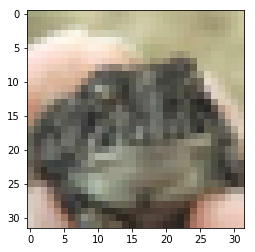

In [32]:
# Sample to plot
sample = 25

# Plot reshaped sample image using grayscale color map
plt.imshow(x_train[sample,:,:,:]) 

# Print true sample class
print ("The true class is " + _CLASS_NAMES[y_train[sample, 0]]) 

## Data Preprocessing
We'll normalize the input data as a prepocessing step

## Define placeholders

Define input and output placeholders. It is a good idea to pass dropout rate also as a placeholder.

In [39]:
x = tf.placeholder(tf.float32, [None, _IMAGE_SIZE, _IMAGE_SIZE, _IMAGE_CHANNELS], name='Input')
y_true = tf.placeholder(tf.float32, [None, _NUM_CLASSES], 'Output')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

## Define variables

Define filters for convolutional layers, weights and biases for fully connected layers. Don't forget to use a initializer. Xavier is recommended.

In [40]:
conv1_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 3, 32], mean=0, stddev=0.08))
conv2_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 32, 16], mean=0, stddev=0.08))
conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 16, 32], mean=0, stddev=0.08))

## Define network

Define the network as a function.Recommended functions are:

`
tf.nn.convolution / tf.nn.pool / tf.nn.batch_normalization / tf.nn.dropout / tf.reshape`

In [41]:
def my_batch(x):
    return tf.nn.batch_normalization(x, tf.mean(x),
                                                                              tf.var(x), None, None,
                                                                              1e-6, name=None)

In [43]:
conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
conv1 = tf.nn.relu(conv1)
conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
conv1_bn = tf.layers.batch_normalization(conv1_pool)

conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
conv2 = tf.nn.relu(conv2)
conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
conv2_bn = tf.layers.batch_normalization(conv2_pool)

conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
conv3 = tf.nn.relu(conv3)
conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
conv3_bn = tf.layers.batch_normalization(conv3_pool)

In [45]:
flat = tf.contrib.layers.flatten(conv3_bn)  

full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
full1 = tf.nn.dropout(full1, keep_prob)
full1 = tf.layers.batch_normalization(full1)

# 11
logits = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=10, activation_fn=None)

## Define cost function

Define cost with respect to predictions and labels.

In [104]:
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

In [105]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true))

## Define optimizer

Adam is recommended

In [106]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

## Define performance measures

In [107]:
# Accuracy
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)
correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Create TensorFlow session


In [108]:
session = tf.Session()

## Initialize variables

The variables for `weights`,`filters` and `biases` must be initialized before we start optimizing them.

In [109]:
session.run(tf.global_variables_initializer())

## Define train function

Don't forget to use batches since dataset is large.

Hint : One of the simplest way to define batch is

`for b in range(dataset_size//batch_size):      
    x_batch = x_train[b * batch_size : (b+1) * batch_size]`

In [110]:
def print_stats(sess, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y_true: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: x_test,
                             y_true: y_test_encoded,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [111]:
def train_neural_network(session, optimizer, keep_probability, batch_size, epochs):

    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        for batch_i in range(_DATASET_SIZE//batch_size):
            x_batch = x_train[batch_i*batch_size:(batch_i+1)*batch_size,:,:,:]
            y_true_batch = y_train_encoded[batch_i*batch_size: (batch_i+1)*batch_size, :]
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch,
                               keep_prob: keep_probability}
            session.run(optimizer, feed_dict=feed_dict_train)

            print('Epoch {:>2}, CIFAR-10 Batch {}: '.format(epoch + 1, batch_i), end='')
            print_stats(session, x_batch, y_true_batch, cost, accuracy)

In [112]:
feed_dict_test = {x: x_test,
                  y_true: y_test_encoded,
                 keep_prob: 1}

## Define test function

In [113]:
def print_accuracy():
    
    # Run the model to get predictions for test data
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    # Get true labels
    cls_true = y_test
    
    # Calculate the difference betweeb predictions and true labels
    correct_prediction = np.equal(cls_pred, cls_true)
    
    # Calculate the total accuracy
    acc = np.mean(correct_prediction)

    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

## Performance before training

The accuracy is expected to be around 10%

In [114]:
print_accuracy()

Accuracy on test-set: 10.0%


## Performance after training

Measure training and test accuracy for at least 10 epochs, show it on a epoch/accuracy graph. The network is expected to reach around 70% accuracy at 10 epochs. 

In [115]:
train_neural_network(session, optimizer, keep_probability, batch_size, epochs)

Epoch  1, CIFAR-10 Batch 0: Loss:    62.7157 Validation Accuracy: 0.103600
Epoch  1, CIFAR-10 Batch 1: Loss:    55.7837 Validation Accuracy: 0.114600
Epoch  1, CIFAR-10 Batch 2: Loss:    39.8012 Validation Accuracy: 0.106500
Epoch  1, CIFAR-10 Batch 3: Loss:    28.6781 Validation Accuracy: 0.102100
Epoch  1, CIFAR-10 Batch 4: Loss:    15.7785 Validation Accuracy: 0.103900
Epoch  1, CIFAR-10 Batch 5: Loss:    15.3414 Validation Accuracy: 0.132800
Epoch  1, CIFAR-10 Batch 6: Loss:    14.4831 Validation Accuracy: 0.126200
Epoch  1, CIFAR-10 Batch 7: Loss:    13.2125 Validation Accuracy: 0.120900
Epoch  1, CIFAR-10 Batch 8: Loss:    10.8807 Validation Accuracy: 0.102900
Epoch  1, CIFAR-10 Batch 9: Loss:     9.8940 Validation Accuracy: 0.102000
Epoch  1, CIFAR-10 Batch 10: Loss:     6.0149 Validation Accuracy: 0.114900
Epoch  1, CIFAR-10 Batch 11: Loss:     5.8570 Validation Accuracy: 0.118400
Epoch  1, CIFAR-10 Batch 12: Loss:     4.8748 Validation Accuracy: 0.116500
Epoch  1, CIFAR-10 Bat

Epoch  1, CIFAR-10 Batch 108: Loss:     2.1380 Validation Accuracy: 0.176500
Epoch  1, CIFAR-10 Batch 109: Loss:     2.1707 Validation Accuracy: 0.174200
Epoch  1, CIFAR-10 Batch 110: Loss:     2.2282 Validation Accuracy: 0.172600
Epoch  1, CIFAR-10 Batch 111: Loss:     2.1894 Validation Accuracy: 0.174500
Epoch  1, CIFAR-10 Batch 112: Loss:     2.2002 Validation Accuracy: 0.175300
Epoch  1, CIFAR-10 Batch 113: Loss:     2.1755 Validation Accuracy: 0.177000
Epoch  1, CIFAR-10 Batch 114: Loss:     2.1489 Validation Accuracy: 0.179100
Epoch  1, CIFAR-10 Batch 115: Loss:     2.2084 Validation Accuracy: 0.182000
Epoch  1, CIFAR-10 Batch 116: Loss:     2.2229 Validation Accuracy: 0.183700
Epoch  1, CIFAR-10 Batch 117: Loss:     2.2580 Validation Accuracy: 0.184200
Epoch  1, CIFAR-10 Batch 118: Loss:     2.1972 Validation Accuracy: 0.183500
Epoch  1, CIFAR-10 Batch 119: Loss:     2.1219 Validation Accuracy: 0.179200
Epoch  1, CIFAR-10 Batch 120: Loss:     2.2528 Validation Accuracy: 0.179000

Epoch  1, CIFAR-10 Batch 215: Loss:     2.0617 Validation Accuracy: 0.212700
Epoch  1, CIFAR-10 Batch 216: Loss:     2.1159 Validation Accuracy: 0.211300
Epoch  1, CIFAR-10 Batch 217: Loss:     2.1938 Validation Accuracy: 0.211800
Epoch  1, CIFAR-10 Batch 218: Loss:     2.0836 Validation Accuracy: 0.213100
Epoch  1, CIFAR-10 Batch 219: Loss:     2.1236 Validation Accuracy: 0.216000
Epoch  1, CIFAR-10 Batch 220: Loss:     2.0940 Validation Accuracy: 0.218800
Epoch  1, CIFAR-10 Batch 221: Loss:     2.0887 Validation Accuracy: 0.220000
Epoch  1, CIFAR-10 Batch 222: Loss:     2.1060 Validation Accuracy: 0.223200
Epoch  1, CIFAR-10 Batch 223: Loss:     2.1138 Validation Accuracy: 0.222500
Epoch  1, CIFAR-10 Batch 224: Loss:     2.1059 Validation Accuracy: 0.224200
Epoch  1, CIFAR-10 Batch 225: Loss:     2.0454 Validation Accuracy: 0.225600
Epoch  1, CIFAR-10 Batch 226: Loss:     2.0633 Validation Accuracy: 0.226600
Epoch  1, CIFAR-10 Batch 227: Loss:     2.1455 Validation Accuracy: 0.228400

Epoch  1, CIFAR-10 Batch 322: Loss:     2.0227 Validation Accuracy: 0.249800
Epoch  1, CIFAR-10 Batch 323: Loss:     2.0481 Validation Accuracy: 0.248900
Epoch  1, CIFAR-10 Batch 324: Loss:     1.9955 Validation Accuracy: 0.252000
Epoch  1, CIFAR-10 Batch 325: Loss:     2.0212 Validation Accuracy: 0.238800
Epoch  1, CIFAR-10 Batch 326: Loss:     1.9666 Validation Accuracy: 0.245200
Epoch  1, CIFAR-10 Batch 327: Loss:     1.9295 Validation Accuracy: 0.264300
Epoch  1, CIFAR-10 Batch 328: Loss:     1.9996 Validation Accuracy: 0.261400
Epoch  1, CIFAR-10 Batch 329: Loss:     1.9765 Validation Accuracy: 0.265400
Epoch  1, CIFAR-10 Batch 330: Loss:     2.0222 Validation Accuracy: 0.262900
Epoch  1, CIFAR-10 Batch 331: Loss:     1.9538 Validation Accuracy: 0.264900
Epoch  1, CIFAR-10 Batch 332: Loss:     2.0165 Validation Accuracy: 0.255400
Epoch  1, CIFAR-10 Batch 333: Loss:     2.0025 Validation Accuracy: 0.251600
Epoch  1, CIFAR-10 Batch 334: Loss:     2.0492 Validation Accuracy: 0.262200

Epoch  2, CIFAR-10 Batch 39: Loss:     1.8529 Validation Accuracy: 0.296800
Epoch  2, CIFAR-10 Batch 40: Loss:     1.9590 Validation Accuracy: 0.296200
Epoch  2, CIFAR-10 Batch 41: Loss:     1.8217 Validation Accuracy: 0.300000
Epoch  2, CIFAR-10 Batch 42: Loss:     1.8761 Validation Accuracy: 0.298300
Epoch  2, CIFAR-10 Batch 43: Loss:     1.6944 Validation Accuracy: 0.300300
Epoch  2, CIFAR-10 Batch 44: Loss:     1.9267 Validation Accuracy: 0.302700
Epoch  2, CIFAR-10 Batch 45: Loss:     1.8501 Validation Accuracy: 0.304400
Epoch  2, CIFAR-10 Batch 46: Loss:     1.7526 Validation Accuracy: 0.304900
Epoch  2, CIFAR-10 Batch 47: Loss:     1.8543 Validation Accuracy: 0.307300
Epoch  2, CIFAR-10 Batch 48: Loss:     1.8067 Validation Accuracy: 0.308600
Epoch  2, CIFAR-10 Batch 49: Loss:     1.7992 Validation Accuracy: 0.307900
Epoch  2, CIFAR-10 Batch 50: Loss:     1.7762 Validation Accuracy: 0.313600
Epoch  2, CIFAR-10 Batch 51: Loss:     1.9111 Validation Accuracy: 0.314600
Epoch  2, CI

Epoch  2, CIFAR-10 Batch 147: Loss:     1.7899 Validation Accuracy: 0.336300
Epoch  2, CIFAR-10 Batch 148: Loss:     1.8003 Validation Accuracy: 0.341100
Epoch  2, CIFAR-10 Batch 149: Loss:     1.8002 Validation Accuracy: 0.341000
Epoch  2, CIFAR-10 Batch 150: Loss:     1.8591 Validation Accuracy: 0.335000
Epoch  2, CIFAR-10 Batch 151: Loss:     1.7517 Validation Accuracy: 0.330200
Epoch  2, CIFAR-10 Batch 152: Loss:     1.8067 Validation Accuracy: 0.334300
Epoch  2, CIFAR-10 Batch 153: Loss:     1.7757 Validation Accuracy: 0.336700
Epoch  2, CIFAR-10 Batch 154: Loss:     1.7978 Validation Accuracy: 0.334500
Epoch  2, CIFAR-10 Batch 155: Loss:     1.8180 Validation Accuracy: 0.338100
Epoch  2, CIFAR-10 Batch 156: Loss:     1.8273 Validation Accuracy: 0.336800
Epoch  2, CIFAR-10 Batch 157: Loss:     1.7436 Validation Accuracy: 0.335800
Epoch  2, CIFAR-10 Batch 158: Loss:     1.7917 Validation Accuracy: 0.336100
Epoch  2, CIFAR-10 Batch 159: Loss:     1.7801 Validation Accuracy: 0.341600

Epoch  2, CIFAR-10 Batch 254: Loss:     1.8036 Validation Accuracy: 0.335400
Epoch  2, CIFAR-10 Batch 255: Loss:     1.8634 Validation Accuracy: 0.324200
Epoch  2, CIFAR-10 Batch 256: Loss:     1.9306 Validation Accuracy: 0.324600
Epoch  2, CIFAR-10 Batch 257: Loss:     1.7752 Validation Accuracy: 0.327200
Epoch  2, CIFAR-10 Batch 258: Loss:     1.7405 Validation Accuracy: 0.329400
Epoch  2, CIFAR-10 Batch 259: Loss:     1.6800 Validation Accuracy: 0.330300
Epoch  2, CIFAR-10 Batch 260: Loss:     1.8719 Validation Accuracy: 0.331400
Epoch  2, CIFAR-10 Batch 261: Loss:     1.8337 Validation Accuracy: 0.335400
Epoch  2, CIFAR-10 Batch 262: Loss:     1.8702 Validation Accuracy: 0.338200
Epoch  2, CIFAR-10 Batch 263: Loss:     1.7697 Validation Accuracy: 0.341800
Epoch  2, CIFAR-10 Batch 264: Loss:     1.7709 Validation Accuracy: 0.341300
Epoch  2, CIFAR-10 Batch 265: Loss:     1.8101 Validation Accuracy: 0.338500
Epoch  2, CIFAR-10 Batch 266: Loss:     1.6271 Validation Accuracy: 0.344900

Epoch  2, CIFAR-10 Batch 361: Loss:     1.6674 Validation Accuracy: 0.364800
Epoch  2, CIFAR-10 Batch 362: Loss:     1.5363 Validation Accuracy: 0.361000
Epoch  2, CIFAR-10 Batch 363: Loss:     1.8148 Validation Accuracy: 0.361900
Epoch  2, CIFAR-10 Batch 364: Loss:     1.7138 Validation Accuracy: 0.361500
Epoch  2, CIFAR-10 Batch 365: Loss:     1.5920 Validation Accuracy: 0.366100
Epoch  2, CIFAR-10 Batch 366: Loss:     1.7192 Validation Accuracy: 0.368700
Epoch  2, CIFAR-10 Batch 367: Loss:     1.6053 Validation Accuracy: 0.367100
Epoch  2, CIFAR-10 Batch 368: Loss:     1.6184 Validation Accuracy: 0.365300
Epoch  2, CIFAR-10 Batch 369: Loss:     1.4310 Validation Accuracy: 0.367300
Epoch  2, CIFAR-10 Batch 370: Loss:     1.6770 Validation Accuracy: 0.367900
Epoch  2, CIFAR-10 Batch 371: Loss:     1.7201 Validation Accuracy: 0.364100
Epoch  2, CIFAR-10 Batch 372: Loss:     1.6784 Validation Accuracy: 0.361500
Epoch  2, CIFAR-10 Batch 373: Loss:     1.6725 Validation Accuracy: 0.364000

Epoch  3, CIFAR-10 Batch 79: Loss:     1.8036 Validation Accuracy: 0.377500
Epoch  3, CIFAR-10 Batch 80: Loss:     1.7070 Validation Accuracy: 0.377800
Epoch  3, CIFAR-10 Batch 81: Loss:     1.8571 Validation Accuracy: 0.380300
Epoch  3, CIFAR-10 Batch 82: Loss:     1.8604 Validation Accuracy: 0.382700
Epoch  3, CIFAR-10 Batch 83: Loss:     1.6511 Validation Accuracy: 0.386200
Epoch  3, CIFAR-10 Batch 84: Loss:     1.5054 Validation Accuracy: 0.380700
Epoch  3, CIFAR-10 Batch 85: Loss:     1.6573 Validation Accuracy: 0.374100
Epoch  3, CIFAR-10 Batch 86: Loss:     1.7491 Validation Accuracy: 0.372300
Epoch  3, CIFAR-10 Batch 87: Loss:     1.5652 Validation Accuracy: 0.374300
Epoch  3, CIFAR-10 Batch 88: Loss:     1.5123 Validation Accuracy: 0.375300
Epoch  3, CIFAR-10 Batch 89: Loss:     1.6975 Validation Accuracy: 0.380700
Epoch  3, CIFAR-10 Batch 90: Loss:     1.5436 Validation Accuracy: 0.386000
Epoch  3, CIFAR-10 Batch 91: Loss:     1.5963 Validation Accuracy: 0.381600
Epoch  3, CI

Epoch  3, CIFAR-10 Batch 186: Loss:     1.5269 Validation Accuracy: 0.403700
Epoch  3, CIFAR-10 Batch 187: Loss:     1.5561 Validation Accuracy: 0.398100
Epoch  3, CIFAR-10 Batch 188: Loss:     1.6426 Validation Accuracy: 0.389600
Epoch  3, CIFAR-10 Batch 189: Loss:     1.5720 Validation Accuracy: 0.387400
Epoch  3, CIFAR-10 Batch 190: Loss:     1.6062 Validation Accuracy: 0.386400
Epoch  3, CIFAR-10 Batch 191: Loss:     1.5330 Validation Accuracy: 0.388100
Epoch  3, CIFAR-10 Batch 192: Loss:     1.5147 Validation Accuracy: 0.386600
Epoch  3, CIFAR-10 Batch 193: Loss:     1.6507 Validation Accuracy: 0.388400
Epoch  3, CIFAR-10 Batch 194: Loss:     1.5595 Validation Accuracy: 0.384600
Epoch  3, CIFAR-10 Batch 195: Loss:     1.5990 Validation Accuracy: 0.387200
Epoch  3, CIFAR-10 Batch 196: Loss:     1.5942 Validation Accuracy: 0.391300
Epoch  3, CIFAR-10 Batch 197: Loss:     1.6582 Validation Accuracy: 0.390200
Epoch  3, CIFAR-10 Batch 198: Loss:     1.6484 Validation Accuracy: 0.384700

Epoch  3, CIFAR-10 Batch 293: Loss:     1.5457 Validation Accuracy: 0.401600
Epoch  3, CIFAR-10 Batch 294: Loss:     1.7220 Validation Accuracy: 0.403100
Epoch  3, CIFAR-10 Batch 295: Loss:     1.5425 Validation Accuracy: 0.408700
Epoch  3, CIFAR-10 Batch 296: Loss:     1.6285 Validation Accuracy: 0.402200
Epoch  3, CIFAR-10 Batch 297: Loss:     1.7836 Validation Accuracy: 0.402600
Epoch  3, CIFAR-10 Batch 298: Loss:     1.5821 Validation Accuracy: 0.401300
Epoch  3, CIFAR-10 Batch 299: Loss:     1.6056 Validation Accuracy: 0.400500
Epoch  3, CIFAR-10 Batch 300: Loss:     1.5799 Validation Accuracy: 0.397800
Epoch  3, CIFAR-10 Batch 301: Loss:     1.5761 Validation Accuracy: 0.401700
Epoch  3, CIFAR-10 Batch 302: Loss:     1.5434 Validation Accuracy: 0.404400
Epoch  3, CIFAR-10 Batch 303: Loss:     1.4533 Validation Accuracy: 0.410000
Epoch  3, CIFAR-10 Batch 304: Loss:     1.5655 Validation Accuracy: 0.408600
Epoch  3, CIFAR-10 Batch 305: Loss:     1.6230 Validation Accuracy: 0.403700

Epoch  4, CIFAR-10 Batch 10: Loss:     1.4916 Validation Accuracy: 0.415200
Epoch  4, CIFAR-10 Batch 11: Loss:     1.6018 Validation Accuracy: 0.411000
Epoch  4, CIFAR-10 Batch 12: Loss:     1.5314 Validation Accuracy: 0.411100
Epoch  4, CIFAR-10 Batch 13: Loss:     1.6703 Validation Accuracy: 0.411800
Epoch  4, CIFAR-10 Batch 14: Loss:     1.3707 Validation Accuracy: 0.414800
Epoch  4, CIFAR-10 Batch 15: Loss:     1.6951 Validation Accuracy: 0.416300
Epoch  4, CIFAR-10 Batch 16: Loss:     1.5136 Validation Accuracy: 0.412300
Epoch  4, CIFAR-10 Batch 17: Loss:     1.5732 Validation Accuracy: 0.418100
Epoch  4, CIFAR-10 Batch 18: Loss:     1.5272 Validation Accuracy: 0.413000
Epoch  4, CIFAR-10 Batch 19: Loss:     1.5217 Validation Accuracy: 0.401300
Epoch  4, CIFAR-10 Batch 20: Loss:     1.5441 Validation Accuracy: 0.400100
Epoch  4, CIFAR-10 Batch 21: Loss:     1.6104 Validation Accuracy: 0.403100
Epoch  4, CIFAR-10 Batch 22: Loss:     1.5259 Validation Accuracy: 0.407500
Epoch  4, CI

Epoch  4, CIFAR-10 Batch 118: Loss:     1.6032 Validation Accuracy: 0.419500
Epoch  4, CIFAR-10 Batch 119: Loss:     1.3893 Validation Accuracy: 0.425500
Epoch  4, CIFAR-10 Batch 120: Loss:     1.6166 Validation Accuracy: 0.423400
Epoch  4, CIFAR-10 Batch 121: Loss:     1.7362 Validation Accuracy: 0.423200
Epoch  4, CIFAR-10 Batch 122: Loss:     1.6042 Validation Accuracy: 0.423700
Epoch  4, CIFAR-10 Batch 123: Loss:     1.5647 Validation Accuracy: 0.420200
Epoch  4, CIFAR-10 Batch 124: Loss:     1.6756 Validation Accuracy: 0.411700
Epoch  4, CIFAR-10 Batch 125: Loss:     1.5967 Validation Accuracy: 0.399900
Epoch  4, CIFAR-10 Batch 126: Loss:     1.6329 Validation Accuracy: 0.401200
Epoch  4, CIFAR-10 Batch 127: Loss:     1.5607 Validation Accuracy: 0.405100
Epoch  4, CIFAR-10 Batch 128: Loss:     1.5190 Validation Accuracy: 0.421900
Epoch  4, CIFAR-10 Batch 129: Loss:     1.5407 Validation Accuracy: 0.422300
Epoch  4, CIFAR-10 Batch 130: Loss:     1.5200 Validation Accuracy: 0.428200

Epoch  4, CIFAR-10 Batch 225: Loss:     1.3505 Validation Accuracy: 0.435200
Epoch  4, CIFAR-10 Batch 226: Loss:     1.4669 Validation Accuracy: 0.440300
Epoch  4, CIFAR-10 Batch 227: Loss:     1.6216 Validation Accuracy: 0.439200
Epoch  4, CIFAR-10 Batch 228: Loss:     1.4083 Validation Accuracy: 0.437500
Epoch  4, CIFAR-10 Batch 229: Loss:     1.4289 Validation Accuracy: 0.433400
Epoch  4, CIFAR-10 Batch 230: Loss:     1.4225 Validation Accuracy: 0.436200
Epoch  4, CIFAR-10 Batch 231: Loss:     1.5029 Validation Accuracy: 0.437800
Epoch  4, CIFAR-10 Batch 232: Loss:     1.5060 Validation Accuracy: 0.440200
Epoch  4, CIFAR-10 Batch 233: Loss:     1.4667 Validation Accuracy: 0.441300
Epoch  4, CIFAR-10 Batch 234: Loss:     1.4336 Validation Accuracy: 0.439700
Epoch  4, CIFAR-10 Batch 235: Loss:     1.4255 Validation Accuracy: 0.434000
Epoch  4, CIFAR-10 Batch 236: Loss:     1.4672 Validation Accuracy: 0.429600
Epoch  4, CIFAR-10 Batch 237: Loss:     1.4803 Validation Accuracy: 0.428600

Epoch  4, CIFAR-10 Batch 332: Loss:     1.7107 Validation Accuracy: 0.444300
Epoch  4, CIFAR-10 Batch 333: Loss:     1.4398 Validation Accuracy: 0.445100
Epoch  4, CIFAR-10 Batch 334: Loss:     1.5481 Validation Accuracy: 0.447000
Epoch  4, CIFAR-10 Batch 335: Loss:     1.5713 Validation Accuracy: 0.447100
Epoch  4, CIFAR-10 Batch 336: Loss:     1.5136 Validation Accuracy: 0.446400
Epoch  4, CIFAR-10 Batch 337: Loss:     1.5032 Validation Accuracy: 0.450000
Epoch  4, CIFAR-10 Batch 338: Loss:     1.4472 Validation Accuracy: 0.448400
Epoch  4, CIFAR-10 Batch 339: Loss:     1.5751 Validation Accuracy: 0.448900
Epoch  4, CIFAR-10 Batch 340: Loss:     1.3715 Validation Accuracy: 0.449400
Epoch  4, CIFAR-10 Batch 341: Loss:     1.4251 Validation Accuracy: 0.448200
Epoch  4, CIFAR-10 Batch 342: Loss:     1.5560 Validation Accuracy: 0.444500
Epoch  4, CIFAR-10 Batch 343: Loss:     1.4087 Validation Accuracy: 0.440800
Epoch  4, CIFAR-10 Batch 344: Loss:     1.4815 Validation Accuracy: 0.442600

Epoch  5, CIFAR-10 Batch 49: Loss:     1.3469 Validation Accuracy: 0.438600
Epoch  5, CIFAR-10 Batch 50: Loss:     1.4048 Validation Accuracy: 0.445000
Epoch  5, CIFAR-10 Batch 51: Loss:     1.5085 Validation Accuracy: 0.452200
Epoch  5, CIFAR-10 Batch 52: Loss:     1.3833 Validation Accuracy: 0.449300
Epoch  5, CIFAR-10 Batch 53: Loss:     1.4329 Validation Accuracy: 0.449300
Epoch  5, CIFAR-10 Batch 54: Loss:     1.4495 Validation Accuracy: 0.450900
Epoch  5, CIFAR-10 Batch 55: Loss:     1.4455 Validation Accuracy: 0.452200
Epoch  5, CIFAR-10 Batch 56: Loss:     1.3383 Validation Accuracy: 0.450400
Epoch  5, CIFAR-10 Batch 57: Loss:     1.4582 Validation Accuracy: 0.449700
Epoch  5, CIFAR-10 Batch 58: Loss:     1.4704 Validation Accuracy: 0.444600
Epoch  5, CIFAR-10 Batch 59: Loss:     1.4786 Validation Accuracy: 0.441600
Epoch  5, CIFAR-10 Batch 60: Loss:     1.4992 Validation Accuracy: 0.440600
Epoch  5, CIFAR-10 Batch 61: Loss:     1.4676 Validation Accuracy: 0.441100
Epoch  5, CI

Epoch  5, CIFAR-10 Batch 156: Loss:     1.4809 Validation Accuracy: 0.458000
Epoch  5, CIFAR-10 Batch 157: Loss:     1.3865 Validation Accuracy: 0.463300
Epoch  5, CIFAR-10 Batch 158: Loss:     1.5106 Validation Accuracy: 0.461200
Epoch  5, CIFAR-10 Batch 159: Loss:     1.4182 Validation Accuracy: 0.459700
Epoch  5, CIFAR-10 Batch 160: Loss:     1.5060 Validation Accuracy: 0.461400
Epoch  5, CIFAR-10 Batch 161: Loss:     1.4958 Validation Accuracy: 0.466300
Epoch  5, CIFAR-10 Batch 162: Loss:     1.3640 Validation Accuracy: 0.465000
Epoch  5, CIFAR-10 Batch 163: Loss:     1.3731 Validation Accuracy: 0.464700
Epoch  5, CIFAR-10 Batch 164: Loss:     1.3876 Validation Accuracy: 0.465100
Epoch  5, CIFAR-10 Batch 165: Loss:     1.3762 Validation Accuracy: 0.464900
Epoch  5, CIFAR-10 Batch 166: Loss:     1.3774 Validation Accuracy: 0.464300
Epoch  5, CIFAR-10 Batch 167: Loss:     1.4321 Validation Accuracy: 0.464800
Epoch  5, CIFAR-10 Batch 168: Loss:     1.3807 Validation Accuracy: 0.464900

Epoch  5, CIFAR-10 Batch 263: Loss:     1.3743 Validation Accuracy: 0.456800
Epoch  5, CIFAR-10 Batch 264: Loss:     1.5311 Validation Accuracy: 0.455200
Epoch  5, CIFAR-10 Batch 265: Loss:     1.4529 Validation Accuracy: 0.457700
Epoch  5, CIFAR-10 Batch 266: Loss:     1.2889 Validation Accuracy: 0.456100
Epoch  5, CIFAR-10 Batch 267: Loss:     1.3640 Validation Accuracy: 0.454200
Epoch  5, CIFAR-10 Batch 268: Loss:     1.5082 Validation Accuracy: 0.457500
Epoch  5, CIFAR-10 Batch 269: Loss:     1.4226 Validation Accuracy: 0.464600
Epoch  5, CIFAR-10 Batch 270: Loss:     1.3442 Validation Accuracy: 0.459900
Epoch  5, CIFAR-10 Batch 271: Loss:     1.3648 Validation Accuracy: 0.456800
Epoch  5, CIFAR-10 Batch 272: Loss:     1.4409 Validation Accuracy: 0.461200
Epoch  5, CIFAR-10 Batch 273: Loss:     1.4562 Validation Accuracy: 0.466800
Epoch  5, CIFAR-10 Batch 274: Loss:     1.3899 Validation Accuracy: 0.467800
Epoch  5, CIFAR-10 Batch 275: Loss:     1.4840 Validation Accuracy: 0.463600

Epoch  5, CIFAR-10 Batch 370: Loss:     1.4092 Validation Accuracy: 0.474400
Epoch  5, CIFAR-10 Batch 371: Loss:     1.4721 Validation Accuracy: 0.471900
Epoch  5, CIFAR-10 Batch 372: Loss:     1.3750 Validation Accuracy: 0.467900
Epoch  5, CIFAR-10 Batch 373: Loss:     1.4200 Validation Accuracy: 0.472600
Epoch  5, CIFAR-10 Batch 374: Loss:     1.4383 Validation Accuracy: 0.473200
Epoch  5, CIFAR-10 Batch 375: Loss:     1.4843 Validation Accuracy: 0.474500
Epoch  5, CIFAR-10 Batch 376: Loss:     1.3413 Validation Accuracy: 0.474500
Epoch  5, CIFAR-10 Batch 377: Loss:     1.3142 Validation Accuracy: 0.471500
Epoch  5, CIFAR-10 Batch 378: Loss:     1.3573 Validation Accuracy: 0.469200
Epoch  5, CIFAR-10 Batch 379: Loss:     1.4617 Validation Accuracy: 0.468400
Epoch  5, CIFAR-10 Batch 380: Loss:     1.4112 Validation Accuracy: 0.466900
Epoch  5, CIFAR-10 Batch 381: Loss:     1.3357 Validation Accuracy: 0.469400
Epoch  5, CIFAR-10 Batch 382: Loss:     1.3726 Validation Accuracy: 0.472000

Epoch  6, CIFAR-10 Batch 88: Loss:     1.2387 Validation Accuracy: 0.474800
Epoch  6, CIFAR-10 Batch 89: Loss:     1.3233 Validation Accuracy: 0.474700
Epoch  6, CIFAR-10 Batch 90: Loss:     1.3221 Validation Accuracy: 0.478500
Epoch  6, CIFAR-10 Batch 91: Loss:     1.2781 Validation Accuracy: 0.480400
Epoch  6, CIFAR-10 Batch 92: Loss:     1.5147 Validation Accuracy: 0.482200
Epoch  6, CIFAR-10 Batch 93: Loss:     1.3602 Validation Accuracy: 0.470300
Epoch  6, CIFAR-10 Batch 94: Loss:     1.3623 Validation Accuracy: 0.462100
Epoch  6, CIFAR-10 Batch 95: Loss:     1.3132 Validation Accuracy: 0.461200
Epoch  6, CIFAR-10 Batch 96: Loss:     1.4453 Validation Accuracy: 0.464600
Epoch  6, CIFAR-10 Batch 97: Loss:     1.5133 Validation Accuracy: 0.473600
Epoch  6, CIFAR-10 Batch 98: Loss:     1.3609 Validation Accuracy: 0.478700
Epoch  6, CIFAR-10 Batch 99: Loss:     1.3831 Validation Accuracy: 0.477800
Epoch  6, CIFAR-10 Batch 100: Loss:     1.2656 Validation Accuracy: 0.471300
Epoch  6, C

Epoch  6, CIFAR-10 Batch 195: Loss:     1.2269 Validation Accuracy: 0.465700
Epoch  6, CIFAR-10 Batch 196: Loss:     1.3270 Validation Accuracy: 0.476200
Epoch  6, CIFAR-10 Batch 197: Loss:     1.3687 Validation Accuracy: 0.484400
Epoch  6, CIFAR-10 Batch 198: Loss:     1.3698 Validation Accuracy: 0.481600
Epoch  6, CIFAR-10 Batch 199: Loss:     1.2534 Validation Accuracy: 0.478900
Epoch  6, CIFAR-10 Batch 200: Loss:     1.3515 Validation Accuracy: 0.487800
Epoch  6, CIFAR-10 Batch 201: Loss:     1.2988 Validation Accuracy: 0.487800
Epoch  6, CIFAR-10 Batch 202: Loss:     1.3472 Validation Accuracy: 0.485800
Epoch  6, CIFAR-10 Batch 203: Loss:     1.1828 Validation Accuracy: 0.476700
Epoch  6, CIFAR-10 Batch 204: Loss:     1.2417 Validation Accuracy: 0.471500
Epoch  6, CIFAR-10 Batch 205: Loss:     1.3281 Validation Accuracy: 0.477700
Epoch  6, CIFAR-10 Batch 206: Loss:     1.3949 Validation Accuracy: 0.490300
Epoch  6, CIFAR-10 Batch 207: Loss:     1.2880 Validation Accuracy: 0.480000

Epoch  6, CIFAR-10 Batch 302: Loss:     1.2878 Validation Accuracy: 0.487300
Epoch  6, CIFAR-10 Batch 303: Loss:     1.1231 Validation Accuracy: 0.486600
Epoch  6, CIFAR-10 Batch 304: Loss:     1.4458 Validation Accuracy: 0.482700
Epoch  6, CIFAR-10 Batch 305: Loss:     1.4318 Validation Accuracy: 0.482500
Epoch  6, CIFAR-10 Batch 306: Loss:     1.3372 Validation Accuracy: 0.490100
Epoch  6, CIFAR-10 Batch 307: Loss:     1.3609 Validation Accuracy: 0.487900
Epoch  6, CIFAR-10 Batch 308: Loss:     1.3661 Validation Accuracy: 0.484300
Epoch  6, CIFAR-10 Batch 309: Loss:     1.5928 Validation Accuracy: 0.484900
Epoch  6, CIFAR-10 Batch 310: Loss:     1.4225 Validation Accuracy: 0.483300
Epoch  6, CIFAR-10 Batch 311: Loss:     1.3198 Validation Accuracy: 0.483800
Epoch  6, CIFAR-10 Batch 312: Loss:     1.1838 Validation Accuracy: 0.481200
Epoch  6, CIFAR-10 Batch 313: Loss:     1.3622 Validation Accuracy: 0.481700
Epoch  6, CIFAR-10 Batch 314: Loss:     1.3586 Validation Accuracy: 0.490500

Epoch  7, CIFAR-10 Batch 19: Loss:     1.2949 Validation Accuracy: 0.489200
Epoch  7, CIFAR-10 Batch 20: Loss:     1.1444 Validation Accuracy: 0.478600
Epoch  7, CIFAR-10 Batch 21: Loss:     1.4216 Validation Accuracy: 0.477000
Epoch  7, CIFAR-10 Batch 22: Loss:     1.2492 Validation Accuracy: 0.486500
Epoch  7, CIFAR-10 Batch 23: Loss:     1.3987 Validation Accuracy: 0.495800
Epoch  7, CIFAR-10 Batch 24: Loss:     1.3127 Validation Accuracy: 0.502500
Epoch  7, CIFAR-10 Batch 25: Loss:     1.2016 Validation Accuracy: 0.500700
Epoch  7, CIFAR-10 Batch 26: Loss:     1.4105 Validation Accuracy: 0.502700
Epoch  7, CIFAR-10 Batch 27: Loss:     1.3336 Validation Accuracy: 0.501400
Epoch  7, CIFAR-10 Batch 28: Loss:     1.1844 Validation Accuracy: 0.499000
Epoch  7, CIFAR-10 Batch 29: Loss:     1.1704 Validation Accuracy: 0.503100
Epoch  7, CIFAR-10 Batch 30: Loss:     1.3263 Validation Accuracy: 0.503300
Epoch  7, CIFAR-10 Batch 31: Loss:     1.2568 Validation Accuracy: 0.503800
Epoch  7, CI

Epoch  7, CIFAR-10 Batch 127: Loss:     1.2740 Validation Accuracy: 0.493800
Epoch  7, CIFAR-10 Batch 128: Loss:     1.1891 Validation Accuracy: 0.504100
Epoch  7, CIFAR-10 Batch 129: Loss:     1.3245 Validation Accuracy: 0.495500
Epoch  7, CIFAR-10 Batch 130: Loss:     1.3044 Validation Accuracy: 0.487600
Epoch  7, CIFAR-10 Batch 131: Loss:     1.3938 Validation Accuracy: 0.491400
Epoch  7, CIFAR-10 Batch 132: Loss:     1.1729 Validation Accuracy: 0.504100
Epoch  7, CIFAR-10 Batch 133: Loss:     1.3403 Validation Accuracy: 0.508900
Epoch  7, CIFAR-10 Batch 134: Loss:     1.2031 Validation Accuracy: 0.505600
Epoch  7, CIFAR-10 Batch 135: Loss:     1.3705 Validation Accuracy: 0.498100
Epoch  7, CIFAR-10 Batch 136: Loss:     1.3046 Validation Accuracy: 0.498400
Epoch  7, CIFAR-10 Batch 137: Loss:     1.1767 Validation Accuracy: 0.504300
Epoch  7, CIFAR-10 Batch 138: Loss:     1.5024 Validation Accuracy: 0.506300
Epoch  7, CIFAR-10 Batch 139: Loss:     1.3414 Validation Accuracy: 0.501800

Epoch  7, CIFAR-10 Batch 234: Loss:     1.1508 Validation Accuracy: 0.504400
Epoch  7, CIFAR-10 Batch 235: Loss:     1.2307 Validation Accuracy: 0.498000
Epoch  7, CIFAR-10 Batch 236: Loss:     1.3126 Validation Accuracy: 0.492300
Epoch  7, CIFAR-10 Batch 237: Loss:     1.2962 Validation Accuracy: 0.493800
Epoch  7, CIFAR-10 Batch 238: Loss:     1.2022 Validation Accuracy: 0.495400
Epoch  7, CIFAR-10 Batch 239: Loss:     1.3707 Validation Accuracy: 0.504200
Epoch  7, CIFAR-10 Batch 240: Loss:     1.4145 Validation Accuracy: 0.496500
Epoch  7, CIFAR-10 Batch 241: Loss:     1.2231 Validation Accuracy: 0.489000
Epoch  7, CIFAR-10 Batch 242: Loss:     1.2767 Validation Accuracy: 0.488300
Epoch  7, CIFAR-10 Batch 243: Loss:     1.3460 Validation Accuracy: 0.492300
Epoch  7, CIFAR-10 Batch 244: Loss:     1.1984 Validation Accuracy: 0.492900
Epoch  7, CIFAR-10 Batch 245: Loss:     1.3919 Validation Accuracy: 0.492500
Epoch  7, CIFAR-10 Batch 246: Loss:     1.2040 Validation Accuracy: 0.495800

Epoch  7, CIFAR-10 Batch 341: Loss:     1.2329 Validation Accuracy: 0.511800
Epoch  7, CIFAR-10 Batch 342: Loss:     1.3874 Validation Accuracy: 0.508300
Epoch  7, CIFAR-10 Batch 343: Loss:     1.2530 Validation Accuracy: 0.509200
Epoch  7, CIFAR-10 Batch 344: Loss:     1.2139 Validation Accuracy: 0.502600
Epoch  7, CIFAR-10 Batch 345: Loss:     1.4366 Validation Accuracy: 0.502000
Epoch  7, CIFAR-10 Batch 346: Loss:     1.3005 Validation Accuracy: 0.504400
Epoch  7, CIFAR-10 Batch 347: Loss:     1.3239 Validation Accuracy: 0.507800
Epoch  7, CIFAR-10 Batch 348: Loss:     1.3178 Validation Accuracy: 0.511000
Epoch  7, CIFAR-10 Batch 349: Loss:     1.1944 Validation Accuracy: 0.504300
Epoch  7, CIFAR-10 Batch 350: Loss:     1.3943 Validation Accuracy: 0.501600
Epoch  7, CIFAR-10 Batch 351: Loss:     1.2076 Validation Accuracy: 0.506900
Epoch  7, CIFAR-10 Batch 352: Loss:     1.2440 Validation Accuracy: 0.514000
Epoch  7, CIFAR-10 Batch 353: Loss:     1.3078 Validation Accuracy: 0.511900

Epoch  8, CIFAR-10 Batch 58: Loss:     1.2999 Validation Accuracy: 0.503300
Epoch  8, CIFAR-10 Batch 59: Loss:     1.3178 Validation Accuracy: 0.514600
Epoch  8, CIFAR-10 Batch 60: Loss:     1.3082 Validation Accuracy: 0.514900
Epoch  8, CIFAR-10 Batch 61: Loss:     1.2306 Validation Accuracy: 0.513900
Epoch  8, CIFAR-10 Batch 62: Loss:     1.2532 Validation Accuracy: 0.508900
Epoch  8, CIFAR-10 Batch 63: Loss:     1.2403 Validation Accuracy: 0.503600
Epoch  8, CIFAR-10 Batch 64: Loss:     1.2458 Validation Accuracy: 0.502700
Epoch  8, CIFAR-10 Batch 65: Loss:     1.2154 Validation Accuracy: 0.504400
Epoch  8, CIFAR-10 Batch 66: Loss:     1.3041 Validation Accuracy: 0.506700
Epoch  8, CIFAR-10 Batch 67: Loss:     1.1272 Validation Accuracy: 0.508100
Epoch  8, CIFAR-10 Batch 68: Loss:     1.3085 Validation Accuracy: 0.517000
Epoch  8, CIFAR-10 Batch 69: Loss:     1.2362 Validation Accuracy: 0.517300
Epoch  8, CIFAR-10 Batch 70: Loss:     1.5123 Validation Accuracy: 0.515100
Epoch  8, CI

Epoch  8, CIFAR-10 Batch 165: Loss:     1.1792 Validation Accuracy: 0.511900
Epoch  8, CIFAR-10 Batch 166: Loss:     1.2565 Validation Accuracy: 0.515400
Epoch  8, CIFAR-10 Batch 167: Loss:     1.3678 Validation Accuracy: 0.513200
Epoch  8, CIFAR-10 Batch 168: Loss:     1.1384 Validation Accuracy: 0.507300
Epoch  8, CIFAR-10 Batch 169: Loss:     1.1745 Validation Accuracy: 0.507200
Epoch  8, CIFAR-10 Batch 170: Loss:     1.4624 Validation Accuracy: 0.510600
Epoch  8, CIFAR-10 Batch 171: Loss:     1.2489 Validation Accuracy: 0.508900
Epoch  8, CIFAR-10 Batch 172: Loss:     1.2274 Validation Accuracy: 0.509600
Epoch  8, CIFAR-10 Batch 173: Loss:     1.1674 Validation Accuracy: 0.505100
Epoch  8, CIFAR-10 Batch 174: Loss:     1.1894 Validation Accuracy: 0.501500
Epoch  8, CIFAR-10 Batch 175: Loss:     1.2575 Validation Accuracy: 0.508600
Epoch  8, CIFAR-10 Batch 176: Loss:     1.1261 Validation Accuracy: 0.520100
Epoch  8, CIFAR-10 Batch 177: Loss:     1.2567 Validation Accuracy: 0.519700

Epoch  8, CIFAR-10 Batch 272: Loss:     1.2226 Validation Accuracy: 0.529900
Epoch  8, CIFAR-10 Batch 273: Loss:     1.2495 Validation Accuracy: 0.530100
Epoch  8, CIFAR-10 Batch 274: Loss:     1.2116 Validation Accuracy: 0.531200
Epoch  8, CIFAR-10 Batch 275: Loss:     1.2889 Validation Accuracy: 0.526300
Epoch  8, CIFAR-10 Batch 276: Loss:     1.1754 Validation Accuracy: 0.520000
Epoch  8, CIFAR-10 Batch 277: Loss:     1.1634 Validation Accuracy: 0.519700
Epoch  8, CIFAR-10 Batch 278: Loss:     1.2820 Validation Accuracy: 0.526800
Epoch  8, CIFAR-10 Batch 279: Loss:     1.2194 Validation Accuracy: 0.529100
Epoch  8, CIFAR-10 Batch 280: Loss:     1.1874 Validation Accuracy: 0.521900
Epoch  8, CIFAR-10 Batch 281: Loss:     1.1859 Validation Accuracy: 0.516000
Epoch  8, CIFAR-10 Batch 282: Loss:     1.3485 Validation Accuracy: 0.516100
Epoch  8, CIFAR-10 Batch 283: Loss:     1.2353 Validation Accuracy: 0.523800
Epoch  8, CIFAR-10 Batch 284: Loss:     1.1768 Validation Accuracy: 0.529700

Epoch  8, CIFAR-10 Batch 379: Loss:     1.3164 Validation Accuracy: 0.505400
Epoch  8, CIFAR-10 Batch 380: Loss:     1.1892 Validation Accuracy: 0.513100
Epoch  8, CIFAR-10 Batch 381: Loss:     1.1445 Validation Accuracy: 0.528400
Epoch  8, CIFAR-10 Batch 382: Loss:     1.1824 Validation Accuracy: 0.528100
Epoch  8, CIFAR-10 Batch 383: Loss:     1.1334 Validation Accuracy: 0.524700
Epoch  8, CIFAR-10 Batch 384: Loss:     1.0322 Validation Accuracy: 0.525600
Epoch  8, CIFAR-10 Batch 385: Loss:     1.3171 Validation Accuracy: 0.528300
Epoch  8, CIFAR-10 Batch 386: Loss:     1.2383 Validation Accuracy: 0.526800
Epoch  8, CIFAR-10 Batch 387: Loss:     1.1495 Validation Accuracy: 0.526700
Epoch  8, CIFAR-10 Batch 388: Loss:     1.1795 Validation Accuracy: 0.524300
Epoch  8, CIFAR-10 Batch 389: Loss:     1.0977 Validation Accuracy: 0.520000
Epoch  9, CIFAR-10 Batch 0: Loss:     1.1061 Validation Accuracy: 0.523400
Epoch  9, CIFAR-10 Batch 1: Loss:     1.0674 Validation Accuracy: 0.523400
Epo

Epoch  9, CIFAR-10 Batch 97: Loss:     1.2432 Validation Accuracy: 0.519500
Epoch  9, CIFAR-10 Batch 98: Loss:     1.1645 Validation Accuracy: 0.522200
Epoch  9, CIFAR-10 Batch 99: Loss:     1.3082 Validation Accuracy: 0.527000
Epoch  9, CIFAR-10 Batch 100: Loss:     1.1160 Validation Accuracy: 0.526400
Epoch  9, CIFAR-10 Batch 101: Loss:     1.2810 Validation Accuracy: 0.529800
Epoch  9, CIFAR-10 Batch 102: Loss:     1.2741 Validation Accuracy: 0.522200
Epoch  9, CIFAR-10 Batch 103: Loss:     1.2255 Validation Accuracy: 0.512700
Epoch  9, CIFAR-10 Batch 104: Loss:     1.3235 Validation Accuracy: 0.512000
Epoch  9, CIFAR-10 Batch 105: Loss:     1.0921 Validation Accuracy: 0.522000
Epoch  9, CIFAR-10 Batch 106: Loss:     1.2447 Validation Accuracy: 0.529600
Epoch  9, CIFAR-10 Batch 107: Loss:     1.2317 Validation Accuracy: 0.533600
Epoch  9, CIFAR-10 Batch 108: Loss:     1.1408 Validation Accuracy: 0.522200
Epoch  9, CIFAR-10 Batch 109: Loss:     1.1993 Validation Accuracy: 0.511900
Ep

Epoch  9, CIFAR-10 Batch 204: Loss:     1.1394 Validation Accuracy: 0.541900
Epoch  9, CIFAR-10 Batch 205: Loss:     1.1473 Validation Accuracy: 0.534900
Epoch  9, CIFAR-10 Batch 206: Loss:     1.2468 Validation Accuracy: 0.532800
Epoch  9, CIFAR-10 Batch 207: Loss:     1.0792 Validation Accuracy: 0.536100
Epoch  9, CIFAR-10 Batch 208: Loss:     1.1917 Validation Accuracy: 0.538400
Epoch  9, CIFAR-10 Batch 209: Loss:     1.2282 Validation Accuracy: 0.533700
Epoch  9, CIFAR-10 Batch 210: Loss:     1.2574 Validation Accuracy: 0.525800
Epoch  9, CIFAR-10 Batch 211: Loss:     1.2472 Validation Accuracy: 0.521600
Epoch  9, CIFAR-10 Batch 212: Loss:     1.1728 Validation Accuracy: 0.528300
Epoch  9, CIFAR-10 Batch 213: Loss:     1.0832 Validation Accuracy: 0.539300
Epoch  9, CIFAR-10 Batch 214: Loss:     1.1942 Validation Accuracy: 0.531700
Epoch  9, CIFAR-10 Batch 215: Loss:     1.2570 Validation Accuracy: 0.522800
Epoch  9, CIFAR-10 Batch 216: Loss:     1.1489 Validation Accuracy: 0.520500

Epoch  9, CIFAR-10 Batch 311: Loss:     1.0833 Validation Accuracy: 0.544200
Epoch  9, CIFAR-10 Batch 312: Loss:     0.9888 Validation Accuracy: 0.545500
Epoch  9, CIFAR-10 Batch 313: Loss:     1.1911 Validation Accuracy: 0.540800
Epoch  9, CIFAR-10 Batch 314: Loss:     1.1081 Validation Accuracy: 0.545200
Epoch  9, CIFAR-10 Batch 315: Loss:     1.1540 Validation Accuracy: 0.542800
Epoch  9, CIFAR-10 Batch 316: Loss:     1.0705 Validation Accuracy: 0.542500
Epoch  9, CIFAR-10 Batch 317: Loss:     1.1188 Validation Accuracy: 0.541900
Epoch  9, CIFAR-10 Batch 318: Loss:     1.1128 Validation Accuracy: 0.538900
Epoch  9, CIFAR-10 Batch 319: Loss:     1.1906 Validation Accuracy: 0.540400
Epoch  9, CIFAR-10 Batch 320: Loss:     1.2449 Validation Accuracy: 0.543300
Epoch  9, CIFAR-10 Batch 321: Loss:     1.1724 Validation Accuracy: 0.545200
Epoch  9, CIFAR-10 Batch 322: Loss:     1.1891 Validation Accuracy: 0.543900
Epoch  9, CIFAR-10 Batch 323: Loss:     1.0437 Validation Accuracy: 0.543700

Epoch 10, CIFAR-10 Batch 28: Loss:     1.0676 Validation Accuracy: 0.544500
Epoch 10, CIFAR-10 Batch 29: Loss:     1.0273 Validation Accuracy: 0.546100
Epoch 10, CIFAR-10 Batch 30: Loss:     1.1761 Validation Accuracy: 0.549900
Epoch 10, CIFAR-10 Batch 31: Loss:     1.1773 Validation Accuracy: 0.546800
Epoch 10, CIFAR-10 Batch 32: Loss:     1.1797 Validation Accuracy: 0.545500
Epoch 10, CIFAR-10 Batch 33: Loss:     1.1335 Validation Accuracy: 0.546300
Epoch 10, CIFAR-10 Batch 34: Loss:     0.9503 Validation Accuracy: 0.550700
Epoch 10, CIFAR-10 Batch 35: Loss:     1.1428 Validation Accuracy: 0.548600
Epoch 10, CIFAR-10 Batch 36: Loss:     1.0299 Validation Accuracy: 0.547000
Epoch 10, CIFAR-10 Batch 37: Loss:     1.1347 Validation Accuracy: 0.550600
Epoch 10, CIFAR-10 Batch 38: Loss:     1.1626 Validation Accuracy: 0.547500
Epoch 10, CIFAR-10 Batch 39: Loss:     1.2872 Validation Accuracy: 0.546200
Epoch 10, CIFAR-10 Batch 40: Loss:     1.1229 Validation Accuracy: 0.539600
Epoch 10, CI

Epoch 10, CIFAR-10 Batch 135: Loss:     1.2002 Validation Accuracy: 0.537700
Epoch 10, CIFAR-10 Batch 136: Loss:     1.1260 Validation Accuracy: 0.542100
Epoch 10, CIFAR-10 Batch 137: Loss:     1.0534 Validation Accuracy: 0.548700
Epoch 10, CIFAR-10 Batch 138: Loss:     1.2918 Validation Accuracy: 0.549500
Epoch 10, CIFAR-10 Batch 139: Loss:     1.1537 Validation Accuracy: 0.550700
Epoch 10, CIFAR-10 Batch 140: Loss:     1.2012 Validation Accuracy: 0.542300
Epoch 10, CIFAR-10 Batch 141: Loss:     1.1092 Validation Accuracy: 0.534700
Epoch 10, CIFAR-10 Batch 142: Loss:     1.1638 Validation Accuracy: 0.530300
Epoch 10, CIFAR-10 Batch 143: Loss:     1.0995 Validation Accuracy: 0.541800
Epoch 10, CIFAR-10 Batch 144: Loss:     1.2280 Validation Accuracy: 0.552400
Epoch 10, CIFAR-10 Batch 145: Loss:     1.1532 Validation Accuracy: 0.552500
Epoch 10, CIFAR-10 Batch 146: Loss:     1.0809 Validation Accuracy: 0.542900
Epoch 10, CIFAR-10 Batch 147: Loss:     1.1568 Validation Accuracy: 0.547500

Epoch 10, CIFAR-10 Batch 242: Loss:     1.0767 Validation Accuracy: 0.534500
Epoch 10, CIFAR-10 Batch 243: Loss:     1.1223 Validation Accuracy: 0.547700
Epoch 10, CIFAR-10 Batch 244: Loss:     1.0525 Validation Accuracy: 0.553300
Epoch 10, CIFAR-10 Batch 245: Loss:     1.2136 Validation Accuracy: 0.547500
Epoch 10, CIFAR-10 Batch 246: Loss:     1.0847 Validation Accuracy: 0.540200
Epoch 10, CIFAR-10 Batch 247: Loss:     1.1589 Validation Accuracy: 0.543900
Epoch 10, CIFAR-10 Batch 248: Loss:     1.1132 Validation Accuracy: 0.547600
Epoch 10, CIFAR-10 Batch 249: Loss:     1.0975 Validation Accuracy: 0.547100
Epoch 10, CIFAR-10 Batch 250: Loss:     1.2300 Validation Accuracy: 0.548100
Epoch 10, CIFAR-10 Batch 251: Loss:     1.1762 Validation Accuracy: 0.545500
Epoch 10, CIFAR-10 Batch 252: Loss:     1.1854 Validation Accuracy: 0.542400
Epoch 10, CIFAR-10 Batch 253: Loss:     1.0909 Validation Accuracy: 0.543300
Epoch 10, CIFAR-10 Batch 254: Loss:     1.0447 Validation Accuracy: 0.549600

Epoch 10, CIFAR-10 Batch 349: Loss:     1.0581 Validation Accuracy: 0.549500
Epoch 10, CIFAR-10 Batch 350: Loss:     1.2406 Validation Accuracy: 0.548100
Epoch 10, CIFAR-10 Batch 351: Loss:     1.0469 Validation Accuracy: 0.540200
Epoch 10, CIFAR-10 Batch 352: Loss:     1.1125 Validation Accuracy: 0.531600
Epoch 10, CIFAR-10 Batch 353: Loss:     1.2725 Validation Accuracy: 0.529200
Epoch 10, CIFAR-10 Batch 354: Loss:     1.1085 Validation Accuracy: 0.537000
Epoch 10, CIFAR-10 Batch 355: Loss:     1.0803 Validation Accuracy: 0.551300
Epoch 10, CIFAR-10 Batch 356: Loss:     1.1427 Validation Accuracy: 0.551100
Epoch 10, CIFAR-10 Batch 357: Loss:     1.1741 Validation Accuracy: 0.539200
Epoch 10, CIFAR-10 Batch 358: Loss:     1.0406 Validation Accuracy: 0.528300
Epoch 10, CIFAR-10 Batch 359: Loss:     1.1593 Validation Accuracy: 0.536000
Epoch 10, CIFAR-10 Batch 360: Loss:     0.9190 Validation Accuracy: 0.546400
Epoch 10, CIFAR-10 Batch 361: Loss:     1.1066 Validation Accuracy: 0.554200

## Close the session

In [103]:
session.close()

## Discussion

Double click here and write discussion. 

## References

[1] [Arm Community](https://community.arm.com)